In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.evaluate import permutation_test

In [2]:
# pip install mlxtend

In [3]:
import pandas as pd
import numpy as np

# Potential Outcomes


## The Data

### An AB Testing Approchaing using Casual Inference

- 'Y1' represents total  chipotle sales for a user, had they been shown a  banner promotion
- 'Y0' represents total  chipotle sales for a user, had they *not* been shown a banner

However, in DoorDash's app, we  assume they created a production experience where they showed the banner to users within 3 miles of a Chipotle and did not show it to users further away.  
- 'near_chipotle' is a binary flag for whether a user's home address was within 3 miles of a Chipotle
- 'production_treatment' is a binary flag for whether the user is shown a banner promotion in DoorDash's production (or primary) app. 
- you should notice, these are identical


# Simple Difference in Outcomes
- B: Recreate what the dataset would look like when run in production. Create a variable *production_Y*, which is the observed outcome for each user. You should be able to do this with the switching equation
- C: Calculate the *Simple Difference In Outcomes*

In [4]:
# A
door= pd.read_csv("week_1_potential_outcomes.csv").drop(columns="Unnamed: 0")
door.head()

,near_chipotle,production_treatment,Y0,Y1
0,1,1,12.27,23.25
1,1,1,14.18,25.77
2,1,1,12.16,19.16
3,1,1,13.99,24.38
4,1,1,14.84,25.21


In [5]:
# B
door["production_Y"] = door["production_treatment"]*door["Y1"] + (1-door["production_treatment"])*door["Y0"]
door.head()

,near_chipotle,production_treatment,Y0,Y1,production_Y
0,1,1,12.27,23.25,23.25
1,1,1,14.18,25.77,25.77
2,1,1,12.16,19.16,19.16
3,1,1,13.99,24.38,24.38
4,1,1,14.84,25.21,25.21


In [8]:
# C Simple Difference In Outcomes

SDO = door.production_Y[door.production_treatment ==1].mean() - door.production_Y[door.production_treatment ==0].mean()

print("Simple Difference In Outcomes:",round(SDO,2))

Simple Difference In Outcomes: 11.53



# Selection Bias

In [13]:
Selection_Bias = door.Y0[door.production_treatment ==1].mean() - door.Y0[door.production_treatment ==0].mean() 

# Average Treatment on Treated

In [22]:
ATT = door.Y1[door.production_treatment ==1].mean() - door.Y0[door.production_treatment ==1].mean() 
ATT

7.454499999999992

# Average Treatment on Untreated

In [21]:
ATU = door.Y1[door.production_treatment ==0].mean() - door.Y0[door.production_treatment ==0].mean() 
ATU

2.860500000000002

# Heterogenus Treatment Effect Bias

In [19]:
# of people treated / # of people in data set
pi = door.production_treatment[door.production_treatment ==1].sum()/door.shape[0]
# E
HTE = (1-pi)*(ATT-ATU)

In [20]:
print("Selection Bias:\n",round(Selection_Bias,2),
     "\nHeterogeneous Treatment Effect Bias\n", round(HTE,2),
     "\nSimple Difference in Outcome\n", round(SDO,2))

Selection Bias:
 4.08 
Heterogeneous Treatment Effect Bias
 2.3 
Simple Difference in Outcome
 11.53



# Calculate the Average Treatment Effect

In [23]:
# F
# SDO = ATE + Selection Bias + HTE
ATE = SDO - Selection_Bias - HTE
# F another method
ATE2 = door.Y1.mean() - door.Y0.mean()



print("Average Treatment Effect:",round(ATE,2),
     "\nAverage Treatment Effect - Method 2:",round(ATE2,2))

Average Treatment Effect: 5.16 
Average Treatment Effect - Method 2: 5.16


In [35]:
SDO == ATE + Selection_Bias + HTE


True

# Simulate an Experiment
If DoorDash ran a randomized experiment, they would have a different data set to observe. Now create what a dataset would look like had the experiment been run
- A: Create a new variable *experiment_treatment*, where a random 50% percent of users are treated with the Banner Promotion, and the other 50% are not
- B: Create a new variable *experiment_y* which is the observed outcome for each user from this hypothetical experiment. 
- C: Calculate the average treatment effect from this experiment
- D: Repeat this calculation 1000 times. Plot a histogram of the estimated average treatment effects. What is the mean and variance of the average treatment effect? (You will be asked to used the reuse the analysis you did in 2B and 2C in problem 3. You may want to make a copy of this dataframe or create a new variable to handle your simulations). 

In [24]:
# 2A
door_sim = door.copy()
door_sim["experiment_treatment"] = np.random.choice([0,1], p=(.5,.5), size =40)

# 2B
door_sim["experiment_y"] = door_sim["experiment_treatment"]*door_sim["Y1"] + (1-door_sim["experiment_treatment"])*door_sim["Y0"]

## 2C 
ATE_exp = door_sim.experiment_y[door_sim.experiment_treatment ==1].mean() - door_sim.experiment_y[door_sim.experiment_treatment ==0].mean()

print("Average Treatment Effect", round(ATE_exp,2))

Average Treatment Effect 5.6


The ATE Mean is: 5.21 
The Standard Deviation is: 1.13 
The Variance is: 1.28


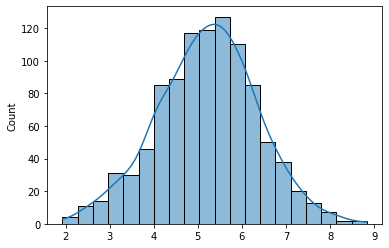

In [25]:
# 2D
ate = []

for i in range(1000):
    door_sim["experiment_treatment"] = np.random.choice([0,1], p=(.5,.5), size =40)
    door_sim["experiment_y"] = door_sim["experiment_treatment"]*door_sim["Y1"] + (1-door_sim["experiment_treatment"])*door_sim["Y0"]
    ATE_sim = door_sim.experiment_y[door_sim.experiment_treatment ==1].mean() - door_sim.experiment_y[door_sim.experiment_treatment ==0].mean()
    ate.append(ATE_sim)

    
sns.histplot(ate, bins=20, kde=True)

print("The ATE Mean is:", round(np.mean(ate),2),
      "\nThe Standard Deviation is:", round(np.std(ate),2),
      "\nThe Variance is:", round(np.var(ate),2))

Permutation Testing

Go back to a dataset like the one you created in 2a and 2b, with one experimental treatment and one experimental outcome. We now want to introduce a new concept called randomization based inference. In this, we compare the outcomes of an experiment against a null hypotheses (called the sharp null) that there is no treatment effect for any individual. 

Under this null hypothesis, we would have expected to see the observed results (*experiment_y*) no matter how treatment was assigned. So we can simulate other, hypothetical experiments,  without changing the outcomes to  calculate average treatment effects. You can read about this approach in *Causal Inference: The Mixtape" (pages 148-163)

- A: Create a new variable *permuted_treatement* with a 50% of being treated and a 50% chance of not being treated
- B: Calculate the average treatment effect under the sharp null hypothesis, using experiment_y and permuted_treatement
- C: Repeat this 1000 times. What is the average of the simulated average treatment effect under the null hypothesis. Plot a histogram of the outcomes
- D: What was the probability of seeing a treatment effect as large the treatment effect calculated in 2C. 
- E: In your words, explain what the probability calculated in 3D means

In [28]:
door_sim.head()

,near_chipotle,production_treatment,Y0,Y1,production_Y,experiment_treatment,experiment_y,permuted_treatement
0,1,1,12.27,23.25,23.25,0,12.27,1
1,1,1,14.18,25.77,25.77,1,25.77,1
2,1,1,12.16,19.16,19.16,1,19.16,0
3,1,1,13.99,24.38,24.38,1,24.38,1
4,1,1,14.84,25.21,25.21,0,14.84,1



ATE 0.07
The ATE Mean is: 0.03 
The Variance is: 2.02


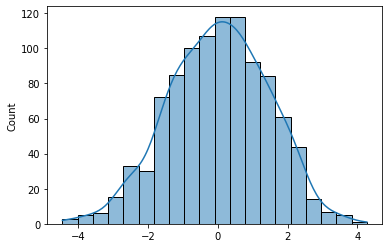

In [34]:
# 3A
door_sim["permuted_treatement"] = np.random.choice([0,1], p=(.5,.5), size =40)

# 3B
ATE_per = door_sim.experiment_y[door_sim.permuted_treatement ==1].mean() - door_sim.experiment_y[door_sim.permuted_treatement ==0].mean()
print("\nATE", round(ATE_per,2))

# 3C
ate_per = []

for i in range(1000):
    door_sim["permuted_treatement"] = np.random.choice([0,1], p=(.5,.5), size =40)
    ATE_per = door_sim.experiment_y[door_sim.permuted_treatement ==1].mean() - door_sim.experiment_y[door_sim.permuted_treatement ==0].mean()
    ate_per.append(ATE_per)
sns.histplot(ate_per, bins=20, kde=True)
print("The ATE Mean is:", round(np.mean(ate_per),2),
      "\nThe Variance is:", round(np.var(ate_per),2))

In [30]:
door_sim = door_sim.sort_values(['permuted_treatement', 'experiment_y'])
door_sim.head()

,near_chipotle,production_treatment,Y0,Y1,production_Y,experiment_treatment,experiment_y,permuted_treatement
23,0,0,9.11,11.37,9.11,0,9.11,0
20,0,0,9.32,14.19,9.32,0,9.32,0
38,0,0,9.44,9.81,9.44,0,9.44,0
29,0,0,9.74,11.83,9.74,0,9.74,0
30,0,0,10.00,8.30,10.00,0,10.00,0


#### 3D
The percentage of having same treatment effect as larage as the once in 2C is very small since the more permuted we test the loweer the average. we can see the p value is 0.34 which might be that our treatment in 2c is less than 3c.

In [31]:
total_per = door_sim.experiment_y[door_sim.permuted_treatement ==1].sum()
total_all = door_sim["experiment_y"].sum()
print("treatment % of Permuted:",round(total_per/total_all,2))

total_sim = door_sim.experiment_y[door_sim.experiment_treatment ==1].sum()
print("Treatment % of Experiement:",round(total_sim/total_all,2))
print("difference", round(total_per/total_all - total_sim/total_all,2))

# p_value
p_value = permutation_test(
    door_sim.experiment_y[door_sim.permuted_treatement ==1],
    door_sim.experiment_y[door_sim.permuted_treatement ==0],
    method = "approximate",
    num_rounds=10000,
    seed=0)
print("P-value",p_value)

treatment % of Permuted: 0.6
Treatment % of Experiement: 0.49
difference 0.11
P-value 0.24977502249775022


### 3E
I wanted to see how is each treatment changes from each experiment by weighing the values of experiemnt_y of only treated users those who did see the banner compared to same in the permuted samples. and did another simulation to calculate permutation p-value from treatment and control to estimate a probability if we have higher permuted results.

In [32]:
np.mean(ate)/40

0.13028383798267645